<a href="https://colab.research.google.com/github/cemorse100/MIR-2023/blob/main/Sound_classification_medleysolosdb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instrument Classification

In this notebook all tasks related to instrument classification will be executed, and their results compared. 

The following tasks will be executed:

- Import the libraries and load the data previously created 
- Implement several algorithms to realize our classification :
  - Supervised learning approach (Support Vector Machines)
  - Supervised learning approach (Neural Network)
  - KNN
  - LDA technique for improving KNN.
- Compare the results and try to conclude

## Install libraries

In [1]:
!pip install pandas
!pip install seaborn
!pip install sklearn
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... don

In [2]:
# We'll need numpy and pandas for basic data wrangling
import numpy as np
import pandas as pd

# We'll need matplotlib and seaborn for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# We'll use some preprocessing from scikit-learn:
#  Standard scaling (z-scoring) and label encoding
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

# Our classifier will be 1-nearest-neighbor after learning the distance metric
from sklearn.neighbors import KNeighborsClassifier

# Pipelines make it a little easier to manage sequences of models,
# eg scaler -> metric learner -> 1nn
from sklearn.pipeline import make_pipeline

# We'll use some standard machinery for reporting accuracy of our models
from sklearn.metrics import classification_report,  plot_confusion_matrix

from sklearn.model_selection import train_test_split


RNG_STATE = 0

from google.colab import files


## Data loading

Please upload the data.csv file generated previously. 

In [5]:
from google.colab import drive
drive.mount('/content/drive')

data_file = '/content/drive/MyDrive/medleysolos_analysis.csv'

#Read data with pandas module

data = pd.read_csv(data_file)

#Plot first lines of our data
data.head()

Mounted at /content/drive


,average_loudness,barkbands_crest.mean,barkbands_crest.stdev,barkbands_flatness_db.mean,barkbands_flatness_db.stdev,barkbands_kurtosis.mean,barkbands_kurtosis.stdev,barkbands_skewness.mean,barkbands_skewness.stdev,barkbands_spread.mean,...,spectral_rolloff.stdev,spectral_skewness.mean,spectral_skewness.stdev,spectral_spread.mean,spectral_spread.stdev,spectral_strongpeak.mean,spectral_strongpeak.stdev,zerocrossingrate.mean,zerocrossingrate.stdev,instrument
0,0.986485,16.137585,2.854650,0.440354,0.046050,3.533163,5.387850,1.585198,1.314781,4.652485,...,428.102356,6.583709,1.664342,1167503.125,4.679665e+05,3.604831,1.952415,0.029482,0.008874,clarinet
1,0.960058,16.703074,4.317982,0.390302,0.069234,4.026202,7.205310,1.280914,1.297541,6.017007,...,519.908691,4.909033,1.626673,1875093.625,1.036963e+06,1.397450,1.750989,0.029316,0.014456,clarinet
2,0.989022,17.286232,4.865179,0.379137,0.050587,2.666015,3.880915,0.477517,1.172807,9.107632,...,531.278015,2.555879,0.741637,1990577.375,6.084969e+05,2.655199,2.983301,0.057791,0.019724,clarinet
3,0.832181,18.056297,5.766200,0.428147,0.093486,23.127003,44.049374,3.228702,3.114851,4.811037,...,446.049927,5.266436,1.917410,1580872.000,1.654716e+06,1.075566,0.944310,0.027684,0.011439,clarinet
4,0.989167,16.251318,4.867145,0.378412,0.059585,2.343408,4.403314,0.602891,0.911431,10.142206,...,652.699829,2.489532,0.937021,2057679.250,1.223489e+06,2.319118,1.841064,0.057284,0.015763,clarinet


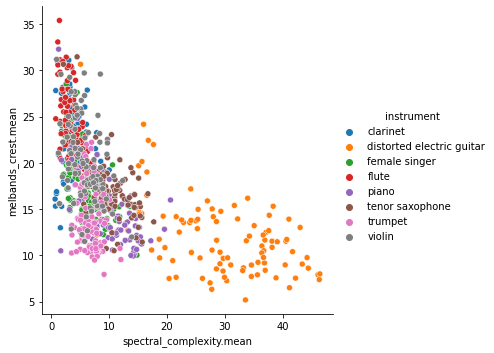

In [6]:
# Take two random features and plot the sample points
import seaborn as sns
sns.relplot(x = "spectral_complexity.mean", y = "melbands_crest.mean", hue = "instrument", data = data);

## Supervised learning approach (Support Vector Machines)

We are first going to use the SVM method, which can only be used for classification tasks.

The principle is simple : each object is represented in a n-dimensional space (n is equal to the number of features). The SVM algorithm is going to try and find the best possible "frontier" to isolate the members of the various classes.

This is a "supervised learning" approach because we have to give a training set where the data has already been labeled with categories we hope to test with.

Here, we have 8 classes (our different instruments) and we have 84 dimensions (our different features).

We also need to decide on train and test sizes. We arbitrarily decide on a 66/33 split. Because we have 800 elements in total, having 264 testing elements should give representative results.

In [12]:
data_modif = data.copy()

#Let's use sklearn's preprocessing tools for applying normalisation to features
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
data_modif.iloc[:,:84] = min_max_scaler.fit_transform(data.iloc[:,:84].values)

In [16]:
# Input values put in a matrix, there are 84 features
X = data_modif.iloc[:,:84].values 
# Creating output values
data_modif.instrument = pd.Categorical(data_modif.instrument)  # convert to categorical data
y = np.array(data_modif.instrument.cat.codes)  # create label encoded outputs
# Print the first sample
print("Features of the first sample: ", X[0])
print("Class of the first sample: ", y[0])

Features of the first sample:  [9.87331762e-01 5.23071516e-01 2.19622269e-01 5.12036648e-01
 9.91938892e-02 4.38537520e-03 2.29804685e-03 5.01408393e-01
 4.33905564e-02 9.87009857e-02 3.99869799e-02 4.83360469e-01
 2.56037162e-01 5.17186403e-02 5.73781544e-01 4.19277035e-01
 5.48921978e-01 7.02752125e-02 1.99661850e-02 2.76695002e-02
 3.19959489e-01 2.66268983e-01 1.47240104e-01 7.39894969e-02
 5.13800813e-01 1.28836692e-01 5.26946883e-01 0.00000000e+00
 8.62033731e-01 1.46408742e-02 5.64836499e-01 0.00000000e+00
 6.28609565e-01 4.55976426e-01 5.85647457e-01 9.72202974e-02
 5.74172143e-03 2.84168963e-03 3.64622429e-01 4.53317903e-02
 9.96485409e-02 6.43373971e-02 3.89107275e-01 4.47753330e-01
 1.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.45021887e-01 9.70312035e-02
 1.18374260e-01 4.81950111e-02 9.02874945e-01 3.81923823e-02
 1.02917993e-01 4.06352216e-02 6.27971410e-04 1.16757580e-03
 3.55259087e-05 1.56268813e-04 3.34957733e-01 2.221169

These results make sense, as the class corresponding to 0 is the clarinet, which is what the first sample is classified as in the dataset. For future reference here are the class identifications as taken from the datasets website:

The list of instrument classes is:

0. clarinet

1. distorted electric guitar

2. female singer

3. flute

4. piano

5. tenor saxophone

6. trumpet

7. violin

Train test splitting using sklearn

In [19]:
# Let's split data into test and train sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

# Check sizes of input and output vectors
print("Size of train features matrix: ",X_train.shape, ", Size of train output vector: ",y_train.shape)
print("Size of test features matrix: ",X_test.shape, ", Size of test output vector: ",y_test.shape)

Size of train features matrix:  (536, 84) , Size of train output vector:  (536,)
Size of test features matrix:  (264, 84) , Size of test output vector:  (264,)


In [20]:
#X_train, X_test, y_train_text, y_test_text = train_test_split(data[data.columns[:-1]],data[data.columns[-1]], test_size=0.2, random_state=RNG_STATE)

In [21]:
# Define and train the model

from sklearn import svm
clf = svm.SVC(gamma = 1 / (X_train.shape[-1] * X_train.var()))

# Fit model with training data
clf.fit(X_train, y_train)

# Predict classes of test samples
y_pred = clf.predict(X_test)

In [22]:
# Test the model
# Let's check for each sample in the test set if prediction matches the true class information
y_test == y_pred

array([False,  True,  True,  True,  True,  True,  True,  True, False,
        True, False,  True,  True,  True, False,  True,  True, False,
       False,  True,  True,  True,  True, False, False,  True,  True,
        True,  True,  True,  True,  True,  True, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False,  True,
        True, False,  True,  True, False,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True, False,  True,
        True, False,  True,  True,  True,  True, False,  True,  True,
        True, False,

In [23]:
# Data is balanced, so you can use accuracy as a measure:
print("accuracy: ", np.sum(y_test == y_pred)/len(y_test))

accuracy:  0.7878787878787878


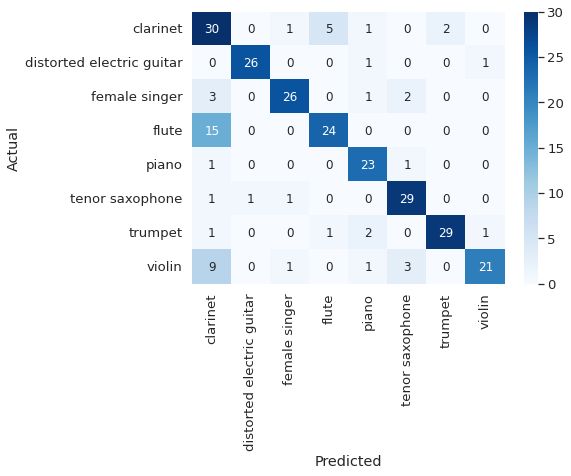

In [24]:
# Print the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

classes = np.unique(data_modif.instrument)
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = classes, index = classes)
conf_mat.index.name = 'Actual'
conf_mat.columns.name = 'Predicted'
plt.figure(figsize = (7, 5))
sns.set(font_scale = 1.2)
sns.heatmap(conf_mat, cmap = "Blues", annot_kws = {"size": 12}, annot = True);

From the SVM model we have achieved classification with about 79% accuracy. While this is already relatively high, lets explore some other methods of classifying to see how different models could compare.

3.3 - Supervised learning approach (Neural Network)
Here, we will implement another supervised learning method : a Neural Network.

This neural network is going to be a Sequential model made with Keras. This API allows us to quickly prototype a neural network.

3.3.1 - Designing the model
We are going to have 4 layers :

Input layer : This layer has a number of input equal to the number of features that we extracted : 84.
Hidden layers : Those layers are going to be used to slowly but surely reduce the number of features. We arbitrariliy decide to divide the input by two to start and can adjust the number of neurons per layer from here to try and achieve more accuracy

1 : We are going to have 42 neurons in this layer. Activation : tanh
2 : We are going to have 21 neurons in this layer. Activation : ReLU.

Output layer : This layer has 8 elements : our 8 instrument classes.
For each layer, we are going to have a Dropout rate. This value means that randomly select neurons will be ignored during training. Their contribution to the activation of downstream neurons is temporally removed and they will not be affected by backward pass.

This aims to prevent overfitting. When a neuron is dropped out, other neurons handle the data instead. This results in a network less sensitive to the specific wieght of neurons and therefore capable of better generalization and therefore less overfitting.


Each hidden layer also has an activation function. This function is responsible for transforming the output of each neuron to introduce non-linearity. We use 2 functions here :

tanh : maps its input to the range of [-1,1]. This function works really well for values near 0.0, but tend to saturate when we reach the limits (-1 and 1).
ReLU : maps its input to the range of [0; inf]. It is computationally efficient and can help solve the "vanishing gradient problem".
Combining those 2 functions in the same model can be beneficial as it allows the model to learn a complex and diverse set of representations.

We need to encode the output labels as numbers, to have them as targets for machine learning models. 

In [25]:
from sklearn.preprocessing import StandardScaler

# Let's start by splitting our data 
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.33, random_state = 1)

# ..and apply normalisation
scaler = StandardScaler().fit(X_train_val)
norm_x_train_val = scaler.transform(X_train_val)
norm_x_test = scaler.transform(X_test)

In [26]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
y_train_val_onehot = onehot_encoder.fit_transform(y_train_val.reshape(len(y_train_val), 1))
y_test_onehot = onehot_encoder.fit_transform(y_test.reshape(len(y_test), 1))
print("One-hot encoded y_train_val shape = ", y_train_val_onehot.shape)
print("One-hot encoded y_test shape = ", y_test_onehot.shape)

One-hot encoded y_train_val shape =  (536, 8)
One-hot encoded y_test shape =  (264, 8)


In [27]:
from keras.models import Sequential
from keras import layers

def compose_model(num_features):
    
    model = Sequential()

    # Input layer 
    model.add(layers.BatchNormalization(name='InputLayer', input_shape=(num_features,)))
    
    # 1. hidden layer
    model.add(layers.Dense(name='HiddenLayer_1', units = 42))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('tanh'))
    model.add(layers.Dropout(0.3))

    # 2. hidden layer
    model.add(layers.Dense(name='HiddenLayer_2', units = 21))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.3))

    # Output layer
    model.add(layers.Dense(name='Output_layer', units = 8))
    model.add(layers.Activation('sigmoid'))
    
    return model

model = compose_model(X_train_val.shape[1])

In [28]:
model.summary()  # Plot summary of the model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (BatchNormalizat  (None, 84)               336       
 ion)                                                            
                                                                 
 HiddenLayer_1 (Dense)       (None, 42)                3570      
                                                                 
 batch_normalization (BatchN  (None, 42)               168       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 42)                0         
                                                                 
 dropout (Dropout)           (None, 42)                0         
                                                                 
 HiddenLayer_2 (Dense)       (None, 21)                9

In [29]:
model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
summary = model.fit(X_train_val, y_train_val_onehot, batch_size = 50, epochs = 250, validation_split=0.2, verbose=0)

In [30]:
score = model.evaluate(X_test, y_test_onehot, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.08778909593820572
Test accuracy: 0.8522727489471436


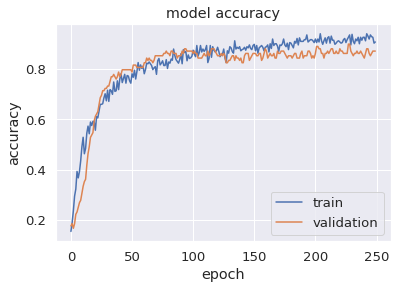

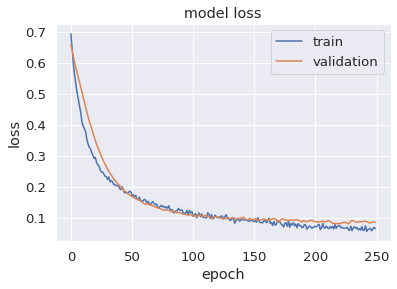

In [32]:
# summarize history for accuracy
plt.plot(summary.history['accuracy'])
plt.plot(summary.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(summary.history['loss'])
plt.plot(summary.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Results
With the first run of the NN we reach 85% accuracy. This is quite high, and satisfactory, since it is an improvement from the SVM model. It is possible that a higher level of accuracy could be achieved, however there is the possibility of overfitting in this case.  

In [ ]:
# We'll need to use a label encoder to encode our instrument
# names as numeric identifiers (0, 1, 2, ..., 9)
encoder = LabelEncoder()

# "Fit" on the training labels; this is really just specifying our vocabulary
# transform maps the encoding over the list of strings to give our encoded label array
y_train = encoder.fit_transform(y_train_text)

# Since the encoder is already fit, we can now transform our test set labels as well
y_test = encoder.transform(y_test_text)

## Feature pre-processing and classification for KNN

Now we will implement the  K-Nearest Neighbors (KNN) Algorithm.

With this album we place the samples in an n-dimensional space based on the features, and compute the distance between a sample and every other one.

A new element is introduced: the testing set. It is placed on the n-dimension space and is classified according to the K closest elements in the space.

The main advantages of this algorithm is its simplicity and the possibility to work a lot of type of data. However, computation can take longer with the growth of the dataset size.

Before actually releasing the classification, we are going to have a standardization step. The StandardScaler() is going to do this, by substracting the mean and dividing by the standard deviation. It is going to ensure that the data has zero mean and unit variance, which is going to improve the performance of the KNN algorithm.

We use a StandardScaler to do a feature normalization such as the input features have a mean zero and standard deviation 1. 
We then build a pipeline chaining the feature pre-processing and the classifier, in this case a KNN 

In [34]:
X_train, X_test, y_train_text, y_test_text = train_test_split(data[data.columns[:-1]],data[data.columns[-1]], test_size=0.2, random_state=RNG_STATE)

We need to encode the output labels as numbers, to have them as targets for machine learning models. 

In [35]:
# We'll need to use a label encoder to encode our instrument
# names as numeric identifiers (0, 1, 2, ..., 9)
encoder = LabelEncoder()

# "Fit" on the training labels; this is really just specifying our vocabulary
# transform maps the encoding over the list of strings to give our encoded label array
y_train = encoder.fit_transform(y_train_text)

# Since the encoder is already fit, we can now transform our test set labels as well
y_test = encoder.transform(y_test_text)

## Feature pre-processing and classification

We use a StandardScaler to do a feature normalization such as the input features have a mean zero and standard deviation 1. 
We then build a pipeline chaining the feature pre-processing and the classifier, in this case a KNN 

                           precision    recall  f1-score   support

                 clarinet       0.55      0.60      0.57        20
distorted electric guitar       0.91      0.83      0.87        12
            female singer       0.89      0.92      0.91        26
                    flute       0.56      0.64      0.60        14
                    piano       0.91      0.71      0.80        28
          tenor saxophone       0.82      0.93      0.87        15
                  trumpet       0.95      1.00      0.98        20
                   violin       0.79      0.76      0.78        25

                 accuracy                           0.80       160
                macro avg       0.80      0.80      0.80       160
             weighted avg       0.81      0.80      0.80       160



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


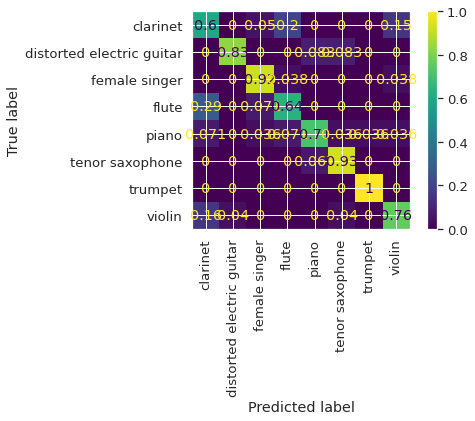

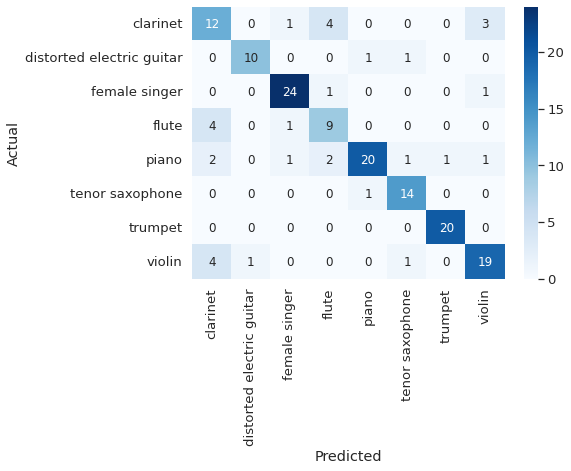

In [47]:
# Our classifier is a "pipeline": scaling followed by KNN
clf = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=1))

# Fit all stages of the pipeline to our training data
clf.fit(X_train, y=y_train)

# How well does our 1-Nearest neighbor model work?
y_pred = clf.predict(X_test)

# Compare our predictions to the true labels in y_test
report = classification_report(y_test, y_pred, target_names=encoder.classes_)

print(report)

# Finally, plot a confusion matrix showing how mistakes are distributed
plot_confusion_matrix(clf, X_test, y_test, display_labels=encoder.classes_, xticks_rotation='vertical', normalize='true');

conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = classes, index = classes)
conf_mat.index.name = 'Actual'
conf_mat.columns.name = 'Predicted'
plt.figure(figsize = (7, 5))
sns.set(font_scale = 1.2)
sns.heatmap(conf_mat, cmap = "Blues", annot_kws = {"size": 12}, annot = True);

In [48]:
# testing, the model. Because the data is balanced, we can use accuracy as a measure
y_test == y_pred
print("Here we achieve an accuracy of ", np.sum(y_test == y_pred)/len(y_test))
     


Here we achieve an accuracy of  0.8


After playing with the size of K, accuracy remained around 0.8, so it was decided to keep K with a value of 1

## Feature visualization

We are going to use Linear Discriminant Analysis (LDA) for dimensionality reduction.

This is a  supervised learning method that finds a  combination of features that best separates two or more classes of data. In our case, it is going to try to separate 8 classes.

The goal is to project a high-dimensional data space (here, our 84 dimenson space) into a lower-dimensional space (here, 8).

LDA can improve the accuracy and interpretability of a classifier.

It works well then the data are well-separated and when the features are uncorrelated. However, it may perform poorly if the classes overlap or if the features are highly correlated.



In [49]:
### How to visualize features using metric learning https://github.com/bmcfee/ismir2020-metric-learning
# scikit-learn provides Linear discriminant analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Finally, umap will let us map high-dimensional data down to 2-d for plotting
import umap

We visualize the data by applying a transformation using UMAP from a high dimensional space to a low dimensional space. Similarly to the PCA reduction, the output axes do not hold any specific meaning.

In [50]:
reducer = umap.UMAP(random_state=RNG_STATE)

# We'll apply all but the last stage (KNN classifier) of our pipeline to the data.
# In this case, we just have one previous stage, which does feature normalization.
# This will change in subsequent examples.

X_train_transformed = clf[:-1].transform(X_train)
X_test_transformed = clf[:-1].transform(X_test)

# Fit on the transformed data, and then transform the test data
embed = reducer.fit_transform(X_train_transformed)
embed_test = reducer.transform(X_test_transformed)

This is a simple visualization of our data. In the plot the different classes are plotted with different colors, while the train and test datasets are denoted by x or circles.
If the test and training data of the same color appear near each other in the visualization, then nearest neighbor classification should work well.

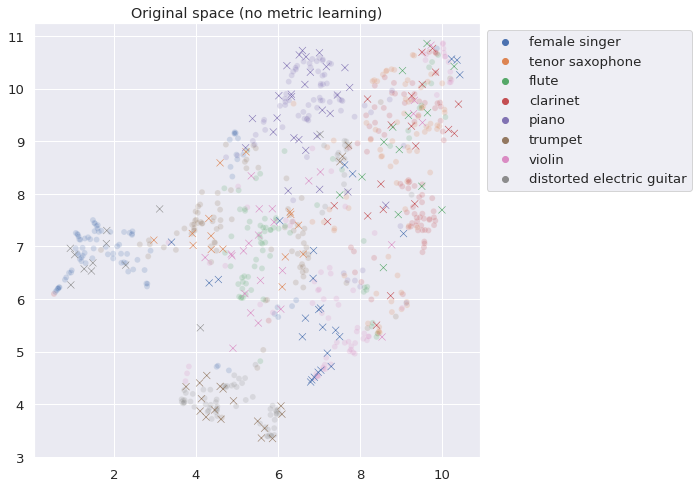

In [51]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x=embed[:, 0], y=embed[:, 1], hue=y_train_text, marker='o', alpha=0.2, legend=None, ax=ax)
sns.scatterplot(x=embed_test[:, 0], y=embed_test[:, 1], hue=y_test_text, marker='x', s=50, alpha=1, legend='brief', ax=ax)
ax.legend(bbox_to_anchor=(1, 1));
ax.set(title='Original space (no metric learning)');

## Linear projection of features

We use Linear Discriminant Analysis to better separate the classes by learning a 9-dimensional projection of the features. 

[Pipeline] .... (step 1 of 3) Processing standardscaler, total=   0.0s
[Pipeline]  (step 2 of 3) Processing lineardiscriminantanalysis, total=   0.1s
[Pipeline]  (step 3 of 3) Processing kneighborsclassifier, total=   0.0s
                           precision    recall  f1-score   support

                 clarinet       0.68      0.65      0.67        20
distorted electric guitar       0.91      0.83      0.87        12
            female singer       0.96      0.96      0.96        26
                    flute       0.71      0.86      0.77        14
                    piano       0.93      0.93      0.93        28
          tenor saxophone       0.93      0.87      0.90        15
                  trumpet       1.00      1.00      1.00        20
                   violin       0.88      0.88      0.88        25

                 accuracy                           0.88       160
                macro avg       0.87      0.87      0.87       160
             weighted avg       0.88  

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


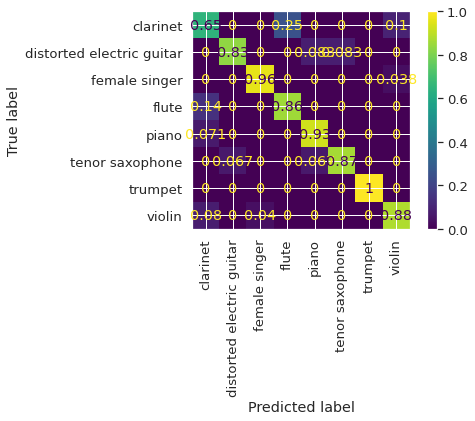

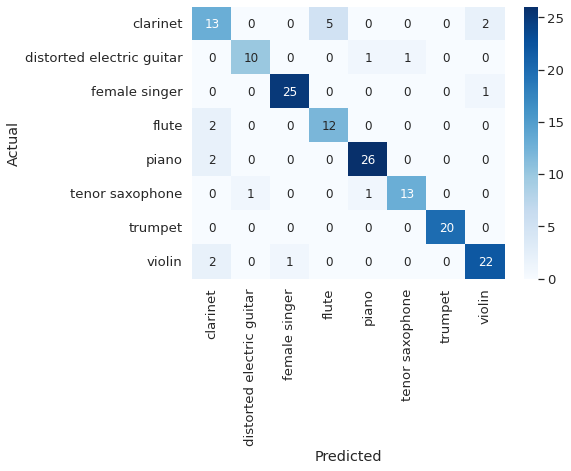

In [57]:
clf = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(), KNeighborsClassifier(n_neighbors=1), verbose=True)
clf.fit(X_train, y=y_train)

y_pred = clf.predict(X_test)

report = classification_report(y_test, y_pred, target_names=encoder.classes_)

print(report)

plot_confusion_matrix(clf, X_test, y_test, display_labels=encoder.classes_, xticks_rotation='vertical', normalize='true');

conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = classes, index = classes)
conf_mat.index.name = 'Actual'
conf_mat.columns.name = 'Predicted'
plt.figure(figsize = (7, 5))
sns.set(font_scale = 1.2)
sns.heatmap(conf_mat, cmap = "Blues", annot_kws = {"size": 12}, annot = True);

Let's visualize the results: 

In [53]:
reducer = umap.UMAP(random_state=RNG_STATE)

# We'll fit the umap embedding on the data after applying our learned transformation
embed = reducer.fit_transform(clf[:-1].transform(X_train))
embed_test = reducer.transform(clf[:-1].transform(X_test))

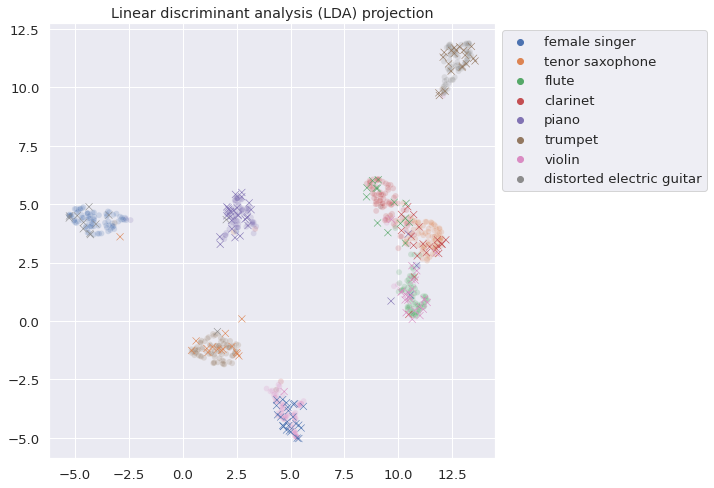

In [54]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x=embed[:, 0], y=embed[:, 1], hue=y_train_text, marker='o', alpha=0.2, legend=None, ax=ax)
sns.scatterplot(x=embed_test[:, 0], y=embed_test[:, 1], hue=y_test_text, marker='x', s=50, alpha=1, legend='brief', ax=ax)
ax.legend(bbox_to_anchor=(1, 1));
ax.set(title='Linear discriminant analysis (LDA) projection');

The projection learned by LDA tells us the weight assigned to each of the training features. 

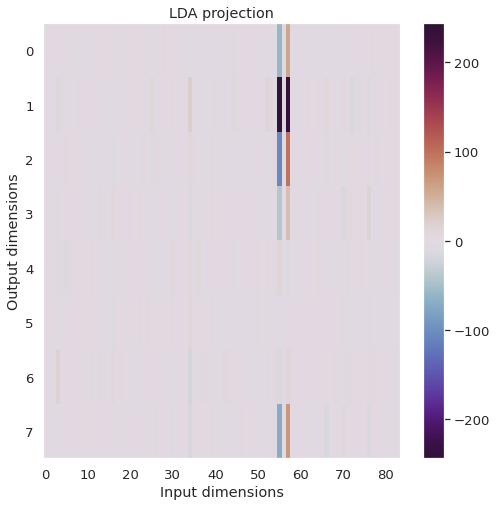

In [55]:
fig, ax = plt.subplots(figsize=(8, 8))
model = clf.steps[1][1]
weights = model.coef_

img = ax.imshow(weights, cmap='twilight_shifted', vmin=-np.abs(weights).max(), vmax=np.abs(weights).max(), aspect='auto', interpolation='none')
fig.colorbar(img, ax=ax)
ax.grid(False)
ax.set(xlabel='Input dimensions', ylabel='Output dimensions', title='LDA projection');

Which features are given more importance? 

In [59]:
# We print the most important weights for each class (for LDA method)

for i in range(len(weights)):
  print(f'For class n°{i+1}')
  print(data.columns[:84][weights[i]>3])
  print('---')

For class n°1
Index(['loudness_ebu128.momentary.mean', 'silence_rate_20dB.mean',
       'spectral_energy.mean', 'spectral_energy.stdev'],
      dtype='object')
---
For class n°2
Index(['barkbands_flatness_db.stdev', 'barkbands_skewness.stdev', 'hfc.stdev',
       'loudness_ebu128.short_term.mean', 'melbands_flatness_db.mean',
       'melbands_spread.mean', 'silence_rate_20dB.mean',
       'silence_rate_20dB.stdev', 'spectral_complexity.mean',
       'spectral_complexity.stdev', 'spectral_decrease.stdev',
       'spectral_energy.mean', 'spectral_energyband_middle_high.mean',
       'spectral_energyband_middle_low.mean', 'spectral_entropy.mean',
       'spectral_kurtosis.mean', 'spectral_rolloff.mean',
       'spectral_strongpeak.stdev'],
      dtype='object')
---
For class n°3
Index(['barkbands_kurtosis.mean', 'erbbands_spread.stdev',
       'loudness_ebu128.integrated', 'melbands_flatness_db.mean',
       'melbands_flatness_db.stdev', 'melbands_skewness.stdev',
       'spectral_decreas

When using LDA we are able to improve accuracy from around 80% to 88%

# Discussion

After using multiple different models we have achieved varying levels of accuracy in the ability to accurately classify instruments in the Medley Solos DB Dataset: 

Support Vector Machine: 78%
Neural Network: 85%
K-Nearest Neighbor: 80%
K-Nearest Neighbor with Linear Discriminant Analysis: 88%

While all models were relatively effective, the KNN with LDA provided the highest accuracy. This model is made more helpful by its ability to provide insight into the most helpful features. Even if the features are not necessarily musical aspects that the human perceptive system can detect, allowing us to take a look at important features is important for reproductability in the future and fitting this classification task to different models. 

